# Simple ML Template — Clean Data Fast

Purpose
-------
Quick template that produces clean, model-ready datasets using the project's preprocessing classes.

What this notebook does
-----------------------
- Load raw data
- Standardize brands with ProductionCarMatcher
- Preprocess features with DataPreprocessor
- Return X_train, X_test, y_train, y_test and a fitted preprocessors

How to use
----------
1. Edit CONFIG at the top to adjust preprocessing options.
2. Run cells in order to regenerate cleaned data.
3. Add modeling cells below; re-run after changing CONFIG to test effects.

Notes
-----
- Optimized for fast iteration and clarity.
- Persist the fitted preprocessor and best model (joblib/pickle) for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import kagglehub
import warnings
import traceback
warnings.filterwarnings('ignore')

# Load preprocessing classes
os.chdir('/Users/leonardodicaterina/Documents/GitHub/ML_group_45')
from utils.preprocessing.CarDatabase import ProductionCarMatcher, create_optimized_database
from utils.preprocessing.Preprocessor_divided import DataPreprocessor

print(" SIMPLE ML TEMPLATE - FAST CLEAN DATA")
print("=" * 45)

# CONFIGURATION - Change these as needed
CONFIG = {
    'random_state': 42,
    'target_column': 'price',
    
    # Preprocessing options
    'outlier_removal': True,          # Remove outliers?
    'feature_scaling': True,          # Scale features?
    'encoding_method': 'mean',        # 'mean', 'onehot'
    'missing_strategy': 'smart',      # 'smart', 'median', 'mean'
    
    # Feature transformations
    'log_transform_mileage': True,    # Log transform mileage?
    'convert_year_to_age': True,      # Convert year to car age?
    'normalize_paint': True,          # Normalize paint quality to 0-1?
    'normalize_engine': True,         # Convert engine size units?
}

print(f" Configuration: {CONFIG}")

/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 SIMPLE ML TEMPLATE - FAST CLEAN DATA
 Configuration: {'random_state': 42, 'target_column': 'price', 'outlier_removal': True, 'feature_scaling': True, 'encoding_method': 'mean', 'missing_strategy': 'smart', 'log_transform_mileage': True, 'convert_year_to_age': True, 'normalize_paint': True, 'normalize_engine': True}


In [2]:
# Load preprocessing classes
os.chdir('/Users/leonardodicaterina/Documents/GitHub/ML_group_45')
from utils.preprocessing.CarDatabase import ProductionCarMatcher, create_optimized_database
from utils.preprocessing.Preprocessor_divided import DataPreprocessor

print("SIMPLE ML TEMPLATE - FAST CLEAN DATA")
print("=" * 45)

# CONFIGURATION - Change these as needed
CONFIG = {
    'random_state': 42,
    'target_column': 'price',
    
    # Preprocessing options
    'outlier_removal': True,          # Remove outliers?
    'feature_scaling': True,          # Scale features?
    'encoding_method': 'mean',        # 'mean', 'onehot'
    'missing_strategy': 'smart',      # 'smart', 'median', 'mean'
    
    # Feature transformations
    'log_transform_mileage': True,    # Log transform mileage?
    'convert_year_to_age': True,      # Convert year to car age?
    'normalize_paint': True,          # Normalize paint quality to 0-1?
    'normalize_engine': True,         # Convert engine size units?
}

print(f"Configuration: {CONFIG}")

SIMPLE ML TEMPLATE - FAST CLEAN DATA
Configuration: {'random_state': 42, 'target_column': 'price', 'outlier_removal': True, 'feature_scaling': True, 'encoding_method': 'mean', 'missing_strategy': 'smart', 'log_transform_mileage': True, 'convert_year_to_age': True, 'normalize_paint': True, 'normalize_engine': True}


In [3]:
raw_train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
path = kagglehub.dataset_download("bourzamraid/global-car-make-and-model-list")
with open(os.path.join(path, 'vehicle models.json'), 'r') as f:
    kaggle_data = json.load(f)
        
# Create matcher and clean brands
optimized_db = create_optimized_database(kaggle_data, max_model_words=3)
matcher = ProductionCarMatcher(optimized_db)
        
_, train_data_results  =  matcher.clean_dataframe(raw_train_data, #.sample(500, random_state=42)
                                        'Brand',
                                        'model')
_, test_data_results  =  matcher.clean_dataframe(test_data, #.sample(200, random_state=42),
                                        'Brand',
                                        'model')
# concat the cleaned data with the target column
train_data = pd.concat([raw_train_data.loc[train_data_results.index], train_data_results[['clean_make', 'clean_model']]], axis=1)
test_data = pd.concat([test_data.loc[test_data_results.index], test_data_results[['clean_make', 'clean_model']]], axis=1)


Analyzing word frequencies...
Created optimized database with 146 makes
Cleaning 75973 records...


Processing records: 100%|██████████| 75973/75973 [03:21<00:00, 376.90it/s]


Cleaning 32567 records...


Processing records: 100%|██████████| 32567/32567 [01:27<00:00, 374.01it/s]


In [4]:
# Define transformations that can be applied to features
def log_transform(x:pd.Series)->pd.Series:
    return np.log1p(np.abs(x)+1)

def year_to_age(year_series:pd.Series)->pd.Series:
    return 2025 - np.abs(np.floor(year_series))

def normalize_paint(paint_series:pd.Series)->pd.Series:
    return np.clip(paint_series, 0, 100) / 100

def normalize_engine(engine_series:pd.Series)->pd.Series:
    result = engine_series.copy()
    small_engines = engine_series <= 10
    result[small_engines] = engine_series[small_engines] * 1000
    return result


In [5]:
# Configure features
feature_configs = {
    'mileage': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'transform_func': log_transform if CONFIG['log_transform_mileage'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'year': {
        'missing_strategy': 'mean',
        'transform_func': year_to_age if CONFIG['convert_year_to_age'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'engineSize': {
        'missing_strategy': 1600,
        'transform_func': normalize_engine if CONFIG['normalize_engine'] else None,
        'scaling_method': 'robust' if CONFIG['feature_scaling'] else None
    },
    'tax': {
        'missing_strategy': 'median',
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'mpg': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'paintQuality%': {
        'missing_strategy': 'median',
        'transform_func': normalize_paint if CONFIG['normalize_paint'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'previousOwners': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.log1p(np.abs(np.floor(x))),
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'hasDamage': {
        'missing_strategy': 1,
        'scaling_method': None
    },
    'Brand_cleaned': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method']
    },
    'transmission': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method']
    },
    'fuelType': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method']
    }
}

In [6]:
data_temp = train_data.sample(frac=0.20, random_state=CONFIG['random_state'])
data_val = train_data.drop(data_temp.index)
data_model_sel = data_temp.sample(frac=0.16, random_state=CONFIG['random_state'])
data_train = data_temp.drop(data_model_sel.index)

print(f"\n✅ DATA SPLIT COMPLETE!")
print(f"   data_train: {data_train.shape}")
print(f"   data_model_sel: {data_model_sel.shape}")
print(f"   data_val: {data_val.shape}")

# fit_transform training data and transform feature selection and validation data
preprocessor = DataPreprocessor(target_column='price')


for feature, feature_config in feature_configs.items():
    if feature in data_train.columns:
        preprocessor.add_feature_pipeline(feature, **feature_config)  
        
X_train, y_train = preprocessor.fit_transform(data_train)
X_model_sel, y__model_sel = preprocessor.transform(data_model_sel)
X_val, y_val = preprocessor.transform(data_val)
X_test, y_test = preprocessor.transform(train_data)

del train_data  # free memory
del data_temp  # free memory



✅ DATA SPLIT COMPLETE!
   data_train: (12764, 16)
   data_model_sel: (2431, 16)
   data_val: (60778, 16)
✓ Fitting pipeline for 'mileage'
✓ Fitting pipeline for 'year'
✓ Fitting pipeline for 'engineSize'
✓ Fitting pipeline for 'tax'
✓ Fitting pipeline for 'mpg'
✓ Fitting pipeline for 'paintQuality%'
✓ Fitting pipeline for 'previousOwners'
✓ Fitting pipeline for 'hasDamage'
✓ Fitting pipeline for 'transmission'
✓ Fitting pipeline for 'fuelType'
✓ Transforming 'mileage'
✓ Transforming 'year'
✓ Transforming 'engineSize'
✓ Transforming 'tax'
✓ Transforming 'mpg'
✓ Transforming 'paintQuality%'
✓ Transforming 'previousOwners'
✓ Transforming 'hasDamage'
✓ Transforming 'transmission'
✓ Transforming 'fuelType'
✓ Transforming 'mileage'
✓ Transforming 'year'
✓ Transforming 'engineSize'
✓ Transforming 'tax'
✓ Transforming 'mpg'
✓ Transforming 'paintQuality%'
✓ Transforming 'previousOwners'
✓ Transforming 'hasDamage'
✓ Transforming 'transmission'
✓ Transforming 'fuelType'
✓ Transforming 'mileage'


## Data is clean — start modeling

Summary
-------
Processed outputs available:
- X_train, X_test — feature matrices (scaled / encoded)
- y_train, y_test — target vectors
- preprocessor — fitted DataPreprocessor (use to transform new data)

Quick checklist
---------------
1. Verify feature set and shapes.
2. Select features and models.
3. Run baseline experiments and record metrics.
4. Persist preprocessor and best model (joblib / pickle).


   Random Forest RMSE: 3400
   Random Forest R²: 0.876

Regression Metrics:
                                      Score  \
Metric                                       
R-squared ($R^2$)                   0.8762   
Explained Variance Score            0.8762   
Root Mean Squared Error (RMSE)  3,399.6045   
Mean Absolute Error (MAE)       1,989.9081   
Median Absolute Error (MedAE)   1,281.8100   

                                                                   Interpretation  
Metric                                                                             
R-squared ($R^2$)               Proportion of variance explained by the model ...  
Explained Variance Score        The variance in the error, a lower value is be...  
Root Mean Squared Error (RMSE)  Average magnitude of errors (same units as tar...  
Mean Absolute Error (MAE)       Average absolute difference between true and p...  
Median Absolute Error (MedAE)   The median of all absolute errors (less sensit...  


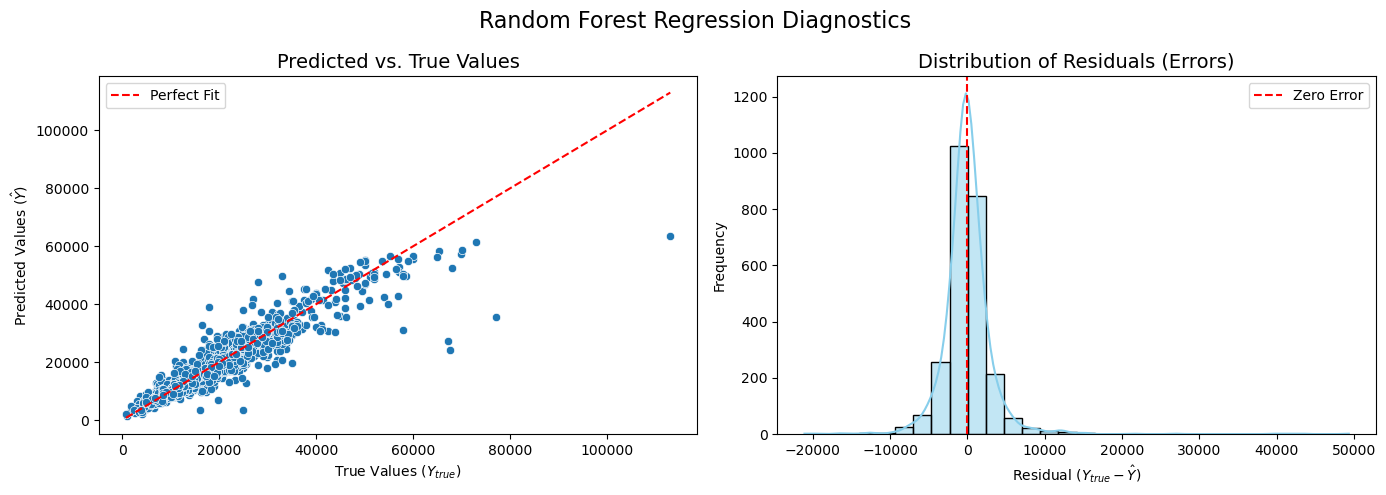

In [7]:
# EXAMPLE: Quick model test
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# split train and valdation
X_train_, X_val_ = X_train.iloc[:int(0.8*len(X_train))], X_train.iloc[int(0.8*len(X_train)):]
y_train_ , y_val_ = y_train.iloc[:int(0.8*len(y_train))], y_train.iloc[int(0.8*len(y_train)):]
X_train_ = X_train_[numerical_features]
X_val_ = X_val_[numerical_features]
# Quick model test
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_, y_train_)

predictions = model.predict(X_val_)
rmse = np.sqrt(mean_squared_error(y_val_, predictions))
r2 = r2_score(y_val_, predictions)

print(f"   Random Forest RMSE: {rmse:.0f}")
print(f"   Random Forest R²: {r2:.3f}")
from utils.model_evaluation.regression_evaluation import get_regression_metrics, plot_regression_diagnostics
metrics_df = get_regression_metrics(y_val_, predictions)
print("\nRegression Metrics:\n", metrics_df)
plot_regression_diagnostics(y_val_, predictions, title="Random Forest Regression Diagnostics")

In [8]:
# let's make a class that, given a model instance and th test data and the colums to use, returns the predicted values paired to the index and saves them to be submitted on kaggle
# also it saves the model to a pickle file for future use and reproducibility
from utils.model_submission.model_submitter import ModelSubmitter
    # Example usage:
submitter = ModelSubmitter(model, X_test, numerical_features)
submitter.save_submission('random_forest_submission.csv')

Submission saved to Submission/20251027_1_random_forest_submission.csv
Model saved to Submission/20251027_1_random_forest_submission_model.pkl
